In [50]:
# !pip install dgl

In [1]:
# should be from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.loggers.comet import CometLogger

In [2]:
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from torch.utils.data import Dataset, DataLoader
import glob
import json
from tqdm.notebook import tqdm
import torch.optim as optim
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

Using backend: pytorch


# Homework 3 - finding shortest path (edge classification)

### The data here is stored in 10,000 json files for each of the training/testing datasets

In [3]:
path_to_ds = './storage/data_for_shortest_path/training_data'
path_to_test_ds = './storage/data_for_shortest_path/test_data'

In [4]:
# import zipfile

In [5]:
# with zipfile.ZipFile('./storage/data_for_shortest_path/test_data.zip', 'r') as zip_ref:
#     zip_ref.extractall('./storage/data_for_shortest_path/')
    
# with zipfile.ZipFile('./storage/data_for_shortest_path/training_data.zip', 'r') as zip_ref:
#     zip_ref.extractall('./storage/data_for_shortest_path/')

In [6]:
# path_to_ds = '/Users/renee/Dropbox/data_for_shortest_path/training_data'
# path_to_test_ds = '/Users/renee/Dropbox/data_for_shortest_path/test_data'

In [7]:
# path_to_ds = 'data/training_data/'
# path_to_test_ds = 'data/test_data/'

### the custom dataset object will load the json files, and then convert the graphs to DGL graphs

In [4]:
class CustomDataset(Dataset):
    def __init__(self, path):
        

        
        filelist = glob.glob(path+'/*.json')
        
        self.graphs = []
        for fname in tqdm(filelist):
            with open(fname) as jfile:
                graph = nx.node_link_graph(json.load(jfile))
                g = dgl.DGLGraph()
                g.from_networkx(graph,node_attrs=['node_features'],edge_attrs=['distance','on_path'])
                
                self.graphs.append(g)
        
        
    def __len__(self):
       
        return len(self.graphs)


    def __getitem__(self, idx):
        
        # dgl graph, target
        return self.graphs[idx], self.graphs[idx].edata['on_path']

### The node features are just 2 numbers - [0,0] for most nodes,
### and [1,0] for the start node, [0,1] for the end node
### the edges all have a property of "distance" which is essentially random
### and a label if they are on the shortest path or not

In [5]:
train_ds = CustomDataset(path_to_ds)
test_ds = CustomDataset(path_to_test_ds)

In [6]:
len(train_ds)

10000

In [7]:
from scipy import stats

In [8]:
stats.describe([train_ds[i][0].number_of_nodes() for i in range(len(train_ds))])

DescribeResult(nobs=10000, minmax=(15, 49), mean=32.9018, variance=92.81603836383638, skewness=-0.07022167191654909, kurtosis=-1.1318416244295055)

In [9]:
stats.describe([train_ds[i][0].number_of_edges() for i in range(len(train_ds))])

DescribeResult(nobs=10000, minmax=(60, 196), mean=131.6072, variance=1485.0566138213821, skewness=-0.07022167191654909, kurtosis=-1.1318416244295055)

In [10]:
# dgl graph
train_ds[495]

(DGLGraph(num_nodes=41, num_edges=164,
          ndata_schemes={'node_features': Scheme(shape=(2,), dtype=torch.float32)}
          edata_schemes={'distance': Scheme(shape=(), dtype=torch.float32), 'on_path': Scheme(shape=(), dtype=torch.int64)}),
 tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]))

In [11]:
train_ds[495][0].edata['distance']

tensor([0.0671, 1.1226, 0.3017, 0.3918, 1.0316, 0.0319, 0.9166, 0.7998, 0.8653,
        0.8833, 0.1934, 1.8276, 1.7674, 0.2350, 1.0523, 1.2554, 1.0316, 1.5836,
        1.7904, 0.4724, 0.4724, 0.1616, 1.2659, 1.2361, 1.1560, 0.9166, 1.4944,
        0.5373, 1.7514, 0.3918, 0.4236, 0.0373, 1.2691, 1.9397, 1.2389, 1.2832,
        0.7504, 0.4674, 1.8276, 1.2974, 1.1591, 1.2871, 0.2065, 0.7313, 1.3919,
        1.4940, 0.5229, 1.5836, 1.5712, 0.7120, 1.0445, 1.0867, 1.6377, 1.2659,
        1.2691, 0.7313, 0.5742, 1.4788, 1.2696, 1.0036, 0.4562, 1.3900, 0.9179,
        1.5691, 0.5229, 1.1238, 0.6833, 1.4788, 1.2043, 1.1423, 0.3739, 0.6417,
        1.2974, 1.1927, 1.2942, 0.5184, 1.7674, 1.9397, 1.5712, 1.2866, 1.3919,
        0.3739, 1.4217, 0.6766, 0.9215, 1.1226, 1.3900, 1.5699, 0.8131, 1.5546,
        0.0373, 1.0036, 1.2866, 0.9215, 1.5500, 1.4485, 0.2350, 1.7514, 1.2043,
        1.4217, 0.9628, 1.2832, 0.7120, 0.6833, 1.2361, 1.0867, 0.8131, 0.8385,
        0.0671, 0.1616, 0.5373, 1.2696, 

In [12]:
train_ds[495][0].ndata['node_features'].size()

torch.Size([41, 2])

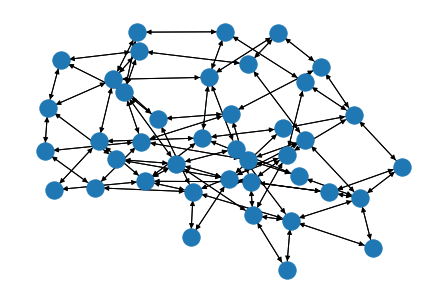

In [13]:
nx.draw( dgl.to_networkx(train_ds[495][0]) )

In [7]:
def collate(samples):
    
    # The input `samples` is a list, a batch of whatever comes out of your dataset object
    
    graphs = [x[0] for x in samples]
    labels = [x[1] for x in samples]
    # dgl.batch creates (one connected?) graph from all of the graphs in the batch
    batched_graph = dgl.batch(graphs,node_attrs=['node_features'],edge_attrs=['distance'])
    targets = torch.cat(labels)
    
    return batched_graph, targets.unsqueeze(1).float()

In [49]:
import torch.nn as nn
import torch.nn.functional as F


#this function is the edge update function - 

class EdgeNetwork(nn.Module):
    def __init__(self, nodemb, edgemb, nodefeat=2):
        super(EdgeNetwork, self).__init__()
        
        # constants
        self.nodemb = nodemb
        self.nodefeat = nodefeat
        self.edgemb = edgemb
           
        self.edgseq = nn.Sequential(

            
            #noderepsize is curr equal nodemb
            nn.Linear(self.nodemb*2 + self.nodefeat*2 + 1, 128),
            
            nn.ReLU(True),
            
            nn.Linear(128, self.edgemb),
            
            nn.ReLU(True)
        )

 # EdgeBatch x       
    def forward(self, x):

        #your input x is an object with the following properties:
        #x.dst['node_features'], x.dst['node_hidden_state']
        #x.src['node_features'], x.src['node_hidden_state']
        #x.data['distance']

    
        data = x.data['distance'].unsqueeze(-1)
                      
        out = torch.cat([x.dst['node_features'],x.dst['node_hidden_state'], x.src['node_features'],x.src['node_hidden_state'],data],dim=1)

        out = self.edgseq(out)

        return {'edge_hidden_representation': out }

class NodeNetwork(nn.Module):
    def __init__(self,nodemb, edgemb, nodefeat=2):
        super(NodeNetwork, self).__init__()
        
        self.edgemb = edgemb
        self.nodefeat = nodefeat
        self.nodemb = nodemb       
        self.nodeseq = nn.Sequential(

            #noderepsize is curr equal nodemb
            nn.Linear(self.nodemb + self.nodefeat+ self.edgemb,128),
            
            nn.ReLU(True),

            nn.Linear(128, self.nodemb),

            nn.ReLU(True)
        )
  
    def forward(self, x):

#         edge_hid_rep_flat = torch.mean(x.mailbox['edge_hidden_representation'],dim=1)
#         edge_hid_rep_flat = edge_hid_rep_flat.squeeze(1)
        
        edge_hid_rep_flat = torch.sum(x.mailbox['edge_hidden_representation'],dim=1,keepdim=False)

        
        out = torch.cat([x.data['node_hidden_state'],x.data['node_features'],edge_hid_rep_flat],dim=1)
        
        out = self.nodeseq(out)
        
#         #- and then apply some fully connected neural network
        # first epoch
#         if out.size()[1] == self.noderep_size + self.nodefeat + self.edgemb:
#             out = F.relu(self.fc1a(out))
            
#         else:
#             out = F.relu(self.fc1b(out))
            
#         out = F.relu(self.fc1(out))
#         out = F.relu(self.fc2(out))
        
        # 1. sum on mailbox
        # 2. concat with node_hidden_state, node_features
        # return a new hidden state for the node, updates hidden states of nodes -- make same size? :/
        return {'node_hidden_state': out }

class EdgeClassifier(nn.Module):
    def __init__(self, nodemb, nodefeat=2):
        super(EdgeClassifier, self).__init__()
        
        self.nodemb = nodemb
        self.nodefeat = nodefeat
        
        self.classeq = nn.Sequential(
        
            nn.Linear(self.nodemb*2 + self.nodefeat*2  +1,self.nodemb),
            nn.ReLU(True),
            nn.Linear(self.nodemb,1),
            # TRY
            nn.Sigmoid()
#             nn.ReLU(True)
        )

   

     
    def forward(self, x):

    
        data = x.data['distance'].unsqueeze(-1)
              
#         print('data.size()',data.size())
        
        out = torch.cat([x.dst['node_features'],x.dst['node_hidden_state'], x.src['node_features'],x.src['node_hidden_state'],data],dim=1)


        out = self.classeq(out)
        
        #put them together with torch.cat
        
        #use a neural network to create an edge hidden represetation - (select size)
        
        #you return a dictionary with what you want to "send" to the reciving node
        
        #sent to nodes

        return {'edge_class_prediction': out }
#         return {'edge_class_prediction': output }

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        # you need to create a network that 
        # will initialize your node hidden state based only on the node features -
#         self.node_representation_size = 32 
        # make everything equal for a minute
#         self.node_representation_size = 64
#         self.edge_representation_size = 128 
        # fc net, linear layers
    
    
        
        self.nodemb = 64 #output of final layer in NodeNetwork
        self.edgemb = 64 #output of final layer in EdgeNetwork  
        
        self.node_init = nn.Sequential(

            nn.Linear(2,128),

            nn.ReLU(True),
            
            nn.Linear(128,self.nodemb),

            nn.ReLU(True)
        )
        
        
#         self.edge_network = EdgeNetwork(self.node_representation_size, self.edgemb)
        self.edge_network = EdgeNetwork(self.nodemb, self.edgemb)
        
        self.node_network = NodeNetwork(self.nodemb, self.edgemb)
        
        self.edge_classifier = EdgeClassifier(self.nodemb)
        
        #this edge classifier is also an edge update function - 
        #but it needs to return something of size 1 (the edge class prediction)
        #so either create a different model for this, or make the EdgeNetwork configurable
        
        # return one number per edge. new module or reconfig EdgeNetwork __init__(self,outputsize,outputname)
        
    def forward(self, g):
        
        # init node_hidden_state to step thru node_init net and populate node_features
        g.ndata['node_hidden_state'] = self.node_init(g.ndata['node_features'])
        
        number_of_iterations = 16
        
        for i in range(number_of_iterations):

            g.update_all(self.edge_network,self.node_network)
            
            # NodeNetwork returns a new hidden state for the node, updates hidden states of nodes of size nodemb -- post-iteration 1
#             self.node_representation_size = self.nodemb
            
            
        # Edge classification task
        # Edge network, return one number per edge

        g.apply_edges(self.edge_classifier)
        
        #and extract its output, should size-match input (from collate()) 
        # output same number of edges as dgl graph
        out = g.edata['edge_class_prediction']

        
        return out 

----------------------------

In [50]:
data_loader_train = DataLoader(train_ds, batch_size=30, shuffle=True, collate_fn=collate,num_workers=4)

In [51]:
for x,y in data_loader_train:                 
    # x is dgl graph -- cant just send to cuda
    x = x.to(torch.device('cuda'))
    y = y.cuda()

In [52]:
net = Classifier()
net.to(torch.device('cuda'))
net(x)

tensor([[0.5025],
        [0.5072],
        [0.5018],
        ...,
        [0.5095],
        [0.5098],
        [0.5093]], device='cuda:0', grad_fn=<SigmoidBackward>)

-----------------------------------

In [53]:
from comet_ml import Experiment

In [56]:
experiment_name = 'graphnet_test_128hid'

In [57]:
project_name = 'dl1010-a3-2'

In [58]:
experiment = Experiment(api_key='n0QCcEJ7YYeDUkff49kqLEdeJ',
    workspace="ren-e1011",
    project_name=project_name)

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/ren-e1011/dl1010-a3-2/2edadbd5fec54f33a549f0e6be1d5d67
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_avgLoss [40]         : (1.1120387098032558, 1.3738219641639802)
COMET INFO:     train_batch_loss [13360]   : (1.027708888053894, 1.4577984809875488)
COMET INFO:     train_falseNegRate [40]    : (0.13177988720495742, 1.0)
COMET INFO:     train_falsePosRate [40]    : (0.0, 0.1865788870296561)
COMET INFO:     train_trueNegRate [40]     : (0.8134211129703439, 1.0)
COMET INFO:     train_truePosRate [40]     : (0.0, 0.8682201127950426)
COMET INFO:     validate_avgLoss [40]      : (1.09901360980051, 1.3507183690270979)
COMET INFO:     validate_falseNegRate [40] : (0.08111467335749466, 1.0)
COMET INFO:     validate_falsePosRate [40] : (0.

In [59]:
# experiment.log_parameters(hyper_params)

In [60]:
from torch.optim import lr_scheduler

In [61]:
net = Classifier()
net = net.to(torch.device('cuda'))
# added in num workers...maybe threading an issue here?
# data_loader_train = DataLoader(train_ds, batch_size=30, shuffle=True, collate_fn=collate, num_workers=4)
data_loader_val = DataLoader(test_ds, batch_size=30, shuffle=True, collate_fn=collate)

#Tweak optimizer lr, scheduler steps
steps = 60
# loss_func = nn.BCEWithLogitsLoss()
loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(16))

# optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)

In [62]:
standing_tpr = .60
standing_tnr = .90

num_epochs = 20
# batch_size = 30

def epoch_metrics(loss,true_positive,false_positive,total_positives,true_negative,false_negative,total_negatives):
    
    avg_loss = np.array(loss).mean()

    truepos_rate = true_positive/total_positives

    falseneg_rate = false_negative/total_positives

    trueneg_rate = true_negative/total_negatives

    falsepos_rate = false_positive/total_negatives

    return {'avgLoss':avg_loss,'truePosRate': truepos_rate,'trueNegRate': trueneg_rate, 'falsePosRate':falsepos_rate, 'falseNegRate':falseneg_rate, }


for epoch in range(num_epochs):
    
    print('EPOCH',epoch)
    print('------------')

    with experiment.train():
        
        net.train()
        
        step = 0
        
        true_positive = 0
        false_positive = 0
        true_negative = 0
        false_negative = 0
        total_positives = 0
        total_negatives = 0
        
        batch_loss = []

        for x,y in data_loader_train:
            
            ## Training
            # x is dgl graph -- cant just send to cuda
            x = x.to(torch.device('cuda'))
            y = y.cuda()

            yhat = net(x)

            loss = loss_func(yhat,y)
            
            optimizer.zero_grad()
            
            #retain_graph?
            loss.backward(retain_graph=True)
            
            optimizer.step() #necessary while using scheduler?
            scheduler.step()

            yhat = yhat.cpu()
            y = y.cpu()
            
            yhat[yhat >= 0.5] = 1
            yhat[yhat <0.5] = 0
            batch_loss.append(loss.item())
            
            total_positives += len(np.where( y==1 )[0])
            total_negatives += len(np.where( y==0 )[0])

            true_positive += len(np.where( (yhat==y) & (y==1) )[0])
            true_negative += len(np.where( (yhat==y) & (y==0) )[0])
            false_positive += len(np.where( (yhat!=y) & (y==0) )[0])
            false_negative += len(np.where( (yhat!=y) & (y==1) )[0])
            
            

            step += 1 

             # Log epoch accuracy to Comet.ml; step is each BATCH
            experiment.log_metric("batch_loss", loss.item())
        train_metrics = epoch_metrics(batch_loss,true_positive,false_positive,total_positives,true_negative,false_negative,total_negatives)
        
        experiment.log_metrics(train_metrics)
           
        print('TRAIN:')
        print(train_metrics)
        
    print('VALIDATION')
    with experiment.validate():
        
        net.eval()
        
        step = 0
        
        true_positive = 0
        false_positive = 0
        true_negative = 0
        false_negative = 0
        total_positives = 0
        total_negatives = 0
        
        val_loss = []
        
        for x,y in data_loader_val:
            
            x = x.to(torch.device('cuda'))
            y = y.cuda()
                    
            yhat = net(x)

            loss = loss_func(yhat,y)
            
            
            yhat = yhat.cpu()
            y = y.cpu()
            val_loss.append(loss.item())

    ###########################################


            yhat[yhat >= 0.5] = 1
            yhat[yhat <0.5] = 0

            total_positives += len(np.where( y==1 )[0])
            total_negatives += len(np.where( y==0 )[0])

            true_positive += len(np.where( (yhat==y) & (y==1) )[0])
            true_negative += len(np.where( (yhat==y) & (y==0) )[0])
            false_positive += len(np.where( (yhat!=y) & (y==0) )[0])
            false_negative += len(np.where( (yhat!=y) & (y==1) )[0])

            step += 1
        
        valid_metrics = epoch_metrics(val_loss,true_positive,false_positive,total_positives,true_negative,false_negative,total_negatives)
        print(valid_metrics)
        
        experiment.log_metrics(valid_metrics)
        print('Epoch',epoch,'end:')
        
        if (valid_metrics['truePosRate'] > standing_tpr) or (valid_metrics['trueNegRate'] > standing_tnr):
            print('Saving Model,Validation TPR',valid_metrics['truePosRate'],'Validation TNR',valid_metrics['trueNegRate'])
            torch.save(net.state_dict(),'shortestpath_tpr_{:.3f}_tnr_{:.3f}.pt'.format(valid_metrics['truePosRate'],  valid_metrics['trueNegRate']))
            standing_tpr = valid_metrics['truePosRate'] 
            stading_tnr = valid_metrics['trueNegRate']
        print('------------')

EPOCH 0
------------
TRAIN:
{'avgLoss': 1.3757482956269544, 'truePosRate': 0.0, 'trueNegRate': 1.0, 'falsePosRate': 0.0, 'falseNegRate': 1.0}
VALIDATION
{'avgLoss': 1.352091784962637, 'truePosRate': 0.0, 'trueNegRate': 1.0, 'falsePosRate': 0.0, 'falseNegRate': 1.0}
Epoch 0 end:
Saving Model,Validation TPR 0.0 Validation TNR 1.0
------------
EPOCH 1
------------
TRAIN:
{'avgLoss': 1.342032129893046, 'truePosRate': 0.0, 'trueNegRate': 1.0, 'falsePosRate': 0.0, 'falseNegRate': 1.0}
VALIDATION
{'avgLoss': 1.3283295049638806, 'truePosRate': 0.0, 'trueNegRate': 1.0, 'falsePosRate': 0.0, 'falseNegRate': 1.0}
Epoch 1 end:
Saving Model,Validation TPR 0.0 Validation TNR 1.0
------------
EPOCH 2
------------
TRAIN:
{'avgLoss': 1.316877614595219, 'truePosRate': 0.09007357207510386, 'trueNegRate': 0.9902731771252575, 'falsePosRate': 0.009726822874742459, 'falseNegRate': 0.9099264279248961}
VALIDATION
{'avgLoss': 1.297984197111187, 'truePosRate': 0.2900636557940712, 'trueNegRate': 0.9538398018166804

In [41]:
net = Classifier()
net.load_state_dict(torch.load('shortestpath_tpr_0.911_tnr_0.918.pt'))


<All keys matched successfully>

In [42]:
net = net.to(torch.device('cuda'))

In [63]:
net

Classifier(
  (node_init): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
  )
  (edge_network): EdgeNetwork(
    (edgseq): Sequential(
      (0): Linear(in_features=133, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (node_network): NodeNetwork(
    (nodeseq): Sequential(
      (0): Linear(in_features=130, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (edge_classifier): EdgeClassifier(
    (classeq): Sequential(
      (0): Linear(in_features=133, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
)

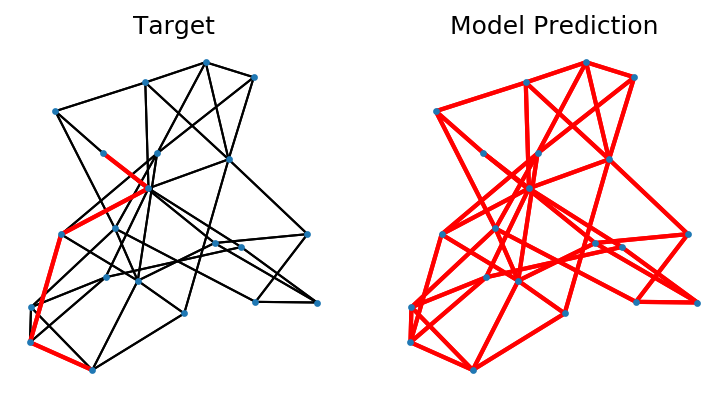

In [64]:
# for debugging

from scipy.special import expit, logit

fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=150)

ax[0].set_title('Target')
ax[1].set_title('Model Prediction')

net.eval()
net.cpu()

dgl_g = test_ds[5578][0]

output_pred = net(dgl_g).data.numpy()

nx_graph = dgl.to_networkx(dgl_g)
pos = {i: dgl_g.ndata['node_features'][i][:2].data.numpy() for i in range(len(dgl_g.ndata['node_features']))} #nx.spring_layout(nx_graph)
edge_list = [e for i,e in enumerate(nx_graph.edges) if dgl_g.edata['on_path'][i]==1]

edge_widths = np.array([expit(output_pred[i][0]) for i in range(len(output_pred))])
predicted_edge_list = [e for i,e in enumerate(nx_graph.edges) if expit(output_pred[i])[0]>=0.5]

pos = nx.spring_layout(nx_graph)


nx.draw( nx_graph ,pos=pos ,ax=ax[0] ,node_size=5,arrows=False)
nx.draw_networkx_edges(nx_graph,pos=pos,edgelist=edge_list,width=2,edge_color='r',ax=ax[0],arrows=False)

nx.draw( nx_graph ,pos=pos ,ax=ax[1] ,node_size=5,arrows=False)
nx.draw_networkx_edges(nx_graph,pos=pos,edgelist=predicted_edge_list,width=2,edge_color='r',ax=ax[1],arrows=False)

plt.show()

### Once you train your network - 
### you can evaluate on the test dataset, and compute the rate of false positive, false negative, etc,
### most of the edges in the dataset have a label 0, so its quite easy to reach a high true negative rate
### but train until you reach at least 60% true positive rate while maintaining a 90%+ true negative rate, and submit

tips
fc net dont need to be big (1,2 hid layers)
hid size can be 10, 50 
number of iterations ~ consider how far node needs to see as to whether it is on the path (closer to n) 